In [84]:
import pickle
import cv2
import numpy as np
import os
from glob import glob
import matplotlib.pyplot as plt
import imgaug as ia
from imgaug import augmenters as iaa
from imgaug.augmentables.bbs import BoundingBox, BoundingBoxesOnImage
from imgaug.augmentables import Keypoint, KeypointsOnImage

Setting up the different directories

In [5]:
DRIVE_DIR = "Porsche/tantrix-data/"
UOB_DIR = "/run/media/mah904/"
HOME_DIR = "/media/markus/"
BASE_DIR = os.path.join(HOME_DIR,DRIVE_DIR)

GRABCUT_DIR = os.path.join(BASE_DIR, "grabcut/")
BOUNDINGBOX_DIR = os.path.join(BASE_DIR, "databb1/")

In [6]:
backgrounds_path = os.path.join(BASE_DIR, "backgrounds.pck")
tiles_pck_fn =  os.path.join(BASE_DIR, "only_tiles.pck")



In [7]:
if not ('backgrounds' in globals()):
    with open(backgrounds_path, "rb") as data:
        backgrounds = pickle.load(data)

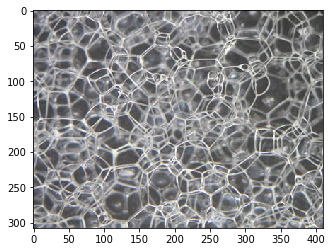

In [9]:
plt.imshow(backgrounds[np.random.randint(len(backgrounds))])

In [25]:
if 1:
    highest_tileNr = 56
    nb_of_tile_set = 2
    tiles = {}
    for i in range(nb_of_tile_set):
        for tileNr in range(1,highest_tileNr+1):
            if tileNr not in tiles:
                tiles[tileNr] = []

            img=cv2.cvtColor(cv2.imread(GRABCUT_DIR+str(i)+"p"+str(tileNr)+".png" ,cv2.IMREAD_UNCHANGED),cv2.COLOR_BGRA2RGBA)
            #thinglist = [img, row[1:]]
            tiles[tileNr].append(img)
    with open(tiles_pck_fn, 'wb') as data:
        pickle.dump(tiles, data)

if not ('tiles' in globals()):
    with open(tiles_pck_fn, "rb") as data:
        tiles = pickle.load(data)


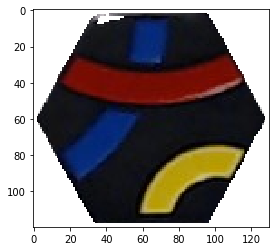

In [29]:

plt.imshow(tiles[1][0])

In [124]:
imgH = 300
imgW = 300

centerX = int(imgW/2)
centerY = int(imgH/2)

marg_alphamask = 2 

h_alphamask = 120
w_alphamask = 130

std_bb_x1 = marg_alphamask
std_bb_y1 = std_bb_x1
std_bb_x2 = w_alphamask - marg_alphamask
std_bb_y2 = h_alphamask - marg_alphamask

In [162]:
def kpts_to_iakpts_list(kpts):
    iakpts_list = []
    for i in range(int(len(kpts)/2)):
        ix=kpts[2*i]
        iy=kpts[2*i+1]
        if not(ix+iy):
            ix = w_alphamask/2
            iy = h_alphamask/2
        iakpts_list.append(ia.Keypoint(x=centerX+ix, y=centerY+iy))
    return ia.KeypointsOnImage(iakpts_list, shape=(imgH, imgW, 3))

def iakpts_to_polygon_rotated(iakpts):
    """
        Convert imgaug keypoints to shapely polygon
    """
    scale_rot = iaa.Sequential([
    iaa.Affine(scale=(1.33)),
    iaa.Affine(rotate=(30))
    ])
    
    kpts_aug = [scale_rot.augment_keypoints([iakpts][0][0])]
    pts = np.zeros((len(kpts_aug[0][0].keypoints),2)) 
    i=0
    for kp in kpts_aug[0][0].keypoints:
        pts[i]=[kp.x,kp.y] 
        i +=1
    CHpts = []
    hull = ConvexHull(pts)
    for j in hull.vertices:
        CHpts.append(pts[j])
    poly = Polygon(CHpts)
    return poly

def iakpts_to_bb(kpts):
    extend=3 # To make the bounding box a little bit bigger
    
    kpsx=[kp.x for kp in kpts.keypoints]
    minx=max(0,int(min(kpsx)-extend))
    maxx=min(imgW,int(max(kpsx)+extend))
    
    kpsy=[kp.y for kp in kpts.keypoints]
    miny=max(0,int(min(kpsy)-extend))
    maxy=min(imgH,int(max(kpsy)+extend))
    
    if minx==maxx or miny==maxy:
        return None
    else:
        return ia.BoundingBox(x1=minx,y1=miny,x2=maxx,y2=maxy)
    

    
def bbs_are_within(list_bb, minx=0, miny=0, maxx=imgW, maxy=imgH):
    for bb in list_bb:
        if bb is None or int(round(bb.x2)) >= maxx or int(round(bb.y2)) >= maxy or int(bb.x1)<=minx or int(bb.y1)<=miny:
            return False
    return True
        
    
        
def augmentImg(img, bb, seq):
    invalid = True

    while invalid:        
        img_aug, bb_aug = seq(image=img, bounding_boxes=bb)
        if bbs_are_within(bb_aug.bounding_boxes):
            invalid = False
            
    return img_aug, bb_aug
        
        
def is_iakpts_intersecting(iakpts1, iakpts2, intersect_ratio=0):
    poly1 = iakpts_to_polygon_rotated(iakpts1)
    
    poly2 = iakpts_to_polygon_rotated(iakpts2)
    p2a = poly2.area
    intersect = poly1.intersection(poly2)
    areal_ratio = (p2a-intersect.area)/p2a
    polys = [poly1, poly2]
    if areal < 1-intersect_ratio:
        return True
    else:
        return False

In [163]:
transform_1tile = iaa.Sequential([
    iaa.Affine(scale=[0.65,1.1]),
    iaa.Affine(rotate=(-180,180)),
    iaa.Affine(translate_percent={"x":(-0.90,0.50),"y":(-0.90,0.50)}),
])

# imgaug transformation for the background
scaleBg=iaa.Scale({"height": imgH, "width": imgW})

/home/markus/.local/lib/python3.6/site-packages/imgaug/imgaug.py:182: DeprecationWarning: Function `Scale()` is deprecated. Use `Resize` instead. Resize has the exactly same interface as Scale.
  warn_deprecated(msg, stacklevel=3)


In [169]:
bgImg = backgrounds[np.random.randint(len(backgrounds))]
tileNr = np.random.randint(1,len(tiles)+1)
print(tileNr)
img1 = tiles[tileNr][np.random.randint(2)]
bb1 = BoundingBox(x1=std_bb_x1, y1=std_bb_y1, x2 =std_bb_x2, y2=std_bb_y2, label=tileNr)
bbs = BoundingBoxesOnImage([bb1], img1.shape)

37


In [170]:
bbs

BoundingBoxesOnImage([BoundingBox(x1=2.0000, y1=2.0000, x2=128.0000, y2=118.0000, label=37)], shape=(120, 130, 4))

KeypointsOnImage([Keypoint(x=2.00000000, y=2.00000000), Keypoint(x=128.00000000, y=2.00000000), Keypoint(x=128.00000000, y=118.00000000), Keypoint(x=2.00000000, y=118.00000000)], shape=(120, 130, 4))

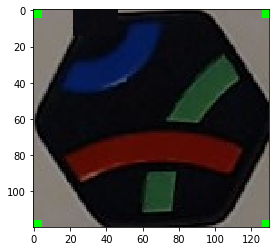

In [171]:
kps = KeypointsOnImage(bb1.to_keypoints(), img1.shape)
img_with_kps = kps.draw_on_image(img1[:,:,0:3], size=5)
plt.imshow(img_with_kps)
kps

In [173]:

        
#Random augment tile
pimg1 = np.zeros((imgH, imgW, 4), dtype=np.uint8)
pimg1[centerY:centerY+h_alphamask, centerX:centerX+w_alphamask] = img1
pimg1_aug, bbs_aug = augmentImg(pimg1, bbs, transform_1tile)

#Scale background to standard size
bg = scaleBg.augment_image(bgImg)
mask1 = np.stack([pimg1_aug[:,:,3]]*3,-1)
final = np.where(mask1, pimg1_aug[:,:,0:3], bg)

finalstring = np.array2string(final)
x_str = np.array_repr(final).replace('\n', '')
final_with_bb = bbs_aug.draw_on_image(final)

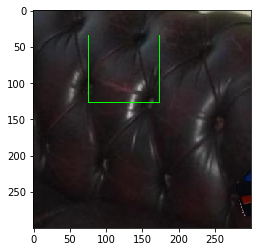

In [174]:
plt.imshow(final_with_bb)

KeypointsOnImage([Keypoint(x=-27.03937149, y=-6.74156952), Keypoint(x=134.57290649, y=-6.74156952), Keypoint(x=134.57290649, y=162.30734253), Keypoint(x=-27.03937149, y=162.30734253)], shape=(300, 300, 3))

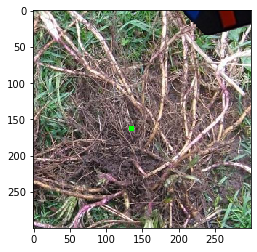

In [129]:
kps = KeypointsOnImage(bbs_aug.to_keypoints(), final.shape)
img_with_kps = kps.draw_on_image(final, size=7)
plt.imshow(img_with_kps)
kps

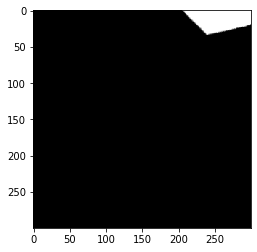

In [130]:

plt.imshow(pimg1_aug)
plt.imshow(mask1)

In [161]:
bbs.bounding_boxes

[BoundingBox(x1=2.0000, y1=2.0000, x2=128.0000, y2=118.0000, label=12)]